<a href="https://colab.research.google.com/github/DangLeUyen/Computer-Vision-From-Scratch/blob/main/flowers_classification_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 flowers classification from scratch using Tensorflow

The following code is based on the book **Practical Machine Learning for Computer Vision** by Valliappa Lakshmanan, Martin Gorner, and Ryan Gillard.

- *Overfitting*: occurs when a model learns training dataset well but performs poorly on the validation or test data.
- *Dense Layer*: a layer of neurons where each neuron is connected to all the neurons in the previous layer.
- *Flattening*: converting a multidimensional tensor into 1D tensor that contains all the values.
- *Activation function*: a function applied to the weighted sum of the inputs to a node, making neuron network nonlinear. Common activation functions include Sigmoid, ReLU, leakyReLU.
  - $\text{Sigmoid}(x) = \frac{1}{1 + e^{-x}}$
  - $\text{ReLU} = \max(0, x)$
  - $\text{LeakyReLU} = \max(0.1x, x)$
- *Softmax*: a special activation function used as the last step in multiclass classifiers. It normalizes the vector to have a sum of 1 so that it can be interpreted as a vector of probabilities.
- *Regularization*: adds a penalty to large weight values. 2 common types:
  - l1 (Lasso): $\text{Loss} = \text{Loss} + \lambda \sum_{i} |w_i|$
  - l2 (Ridge): $\text{Loss} = \text{Loss} + \lambda \sum_{i} (w_i)^2$
- *Dropout*: randomly "drop" (i.e set to zero) a fraction of neurons in a layer at each forward pass. Dropout is only applied during training.
- *Batch Normalization*: normalizes activations in intermediate layes to zero mean and unit variance (mean = 0, variance = 1).
- *Early Stopping*: stops training when the model starts to overfit.
- *Epoch*: a full pass through the training dataset during training.

### Import necessary libraries

In [90]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.core import history
import PIL
import pathlib

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Common functions

In [91]:
# def read_and_decode(filename, reshape_dims):
#   # Read the file
#   img = tf.io.read_file(filename)
#   # Convert the compressed string to a 3D uint8 tensor. Note uint8 in the range [0, 255]
#   img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
#   # Convert the uint 8 to float in the [0,1] range
#   img = tf.image.convert_image_dtype(img, tf.float32)
#   # Resize the image to the desired size
#   img = tf.image.resize(img, reshape_dims)

#   return img

# def parse_csvline(csv_line):
#   # Record_default specify the data types for each column
#   record_default = ["", ""]
#   filename, label_string = tf.io.decode_csv(csv_line, record_defaults=record_default)

#   # Load the image
#   img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])

#   # Convert label string to integer based on the CLASS_NAMES index
#   label = tf.argmax(tf.cast(tf.math.equal(CLASS_NAMES, label_string), tf.int32))

#   return img, label

def train(train_dataset, validation_dataset, model, early_stopping=False, num_epochs=10):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
    )

  callbacks = []

  if early_stopping:
      callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True))

  history = model.fit(train_dataset,
              validation_data = validation_dataset,
              epochs = num_epochs,
              callbacks = callbacks
              )
  return history

def plot_results(history):
  plt.plot(history.history['loss'], label='training loss')
  plt.plot(history.history['val_loss'], label = 'validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

  plt.plot(history.history['accuracy'], label='training accuracy')
  plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()



### Load datasets

In [92]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)


In [93]:
data_dir = pathlib.Path(data_dir)
list(data_dir.glob('flower_photos/*/*.jpg'))[:5]


[PosixPath('datasets/flower_photos/flower_photos/roses/3634244527_e72c47842c_n.jpg'),
 PosixPath('datasets/flower_photos/flower_photos/roses/4723876257_d87b781986.jpg'),
 PosixPath('datasets/flower_photos/flower_photos/roses/509239741_28e2cfe492_m.jpg'),
 PosixPath('datasets/flower_photos/flower_photos/roses/5159317458_bbb22e2f65_n.jpg'),
 PosixPath('datasets/flower_photos/flower_photos/roses/14019883858_e5d2a0ec10_n.jpg')]

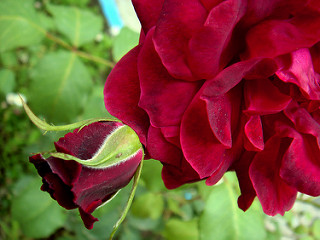

In [94]:

roses = list(data_dir.glob('flower_photos/roses/*'))
PIL.Image.open(str(roses[0]))


In [95]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 15

data_dir = pathlib.Path('datasets/flowers/flower_photos')

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

CLASS_NAMES = train_dataset.class_names
print("Classes:", CLASS_NAMES)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [96]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset   = val_dataset.prefetch(AUTOTUNE)


In [97]:
for images, labels in train_dataset.take(1):
    print(labels)
    print(labels.dtype)


tf.Tensor(
[1 0 4 3 1 2 0 4 4 1 1 4 3 1 1 4 0 3 3 1 1 1 3 2 4 4 4 3 2 2 0 3 0 2 4 4 4
 1 1 1 1 1 3 0 1 2 3 0 1 3 0 0 4 3 4 2 4 1 4 1 4 0 2 0], shape=(64,), dtype=int32)
<dtype: 'int32'>


for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)


### Training a linear neural network

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.2788 - loss: 31.5183 - val_accuracy: 0.4292 - val_loss: 5.8188
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.4365 - loss: 5.6348 - val_accuracy: 0.3951 - val_loss: 5.3104
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.4574 - loss: 3.6122 - val_accuracy: 0.3433 - val_loss: 5.4780
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.4775 - loss: 3.7218 - val_accuracy: 0.2398 - val_loss: 12.8349
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.4180 - loss: 5.9520 - val_accuracy: 0.3583 - val_loss: 5.0187
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.5636 - loss: 2.8551 - val_accuracy: 0.3978 - val_loss: 4.5763
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.5765 - loss: 2.3500 - val_accuracy: 0.2629 - val_loss: 15.4778
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.4808 - loss: 5.9391 - val_accurac

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_16 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 5)              │       752,645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,937 (8.61 MB)

 Trainable params: 752,645 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,505,292 (5.74 MB)

None


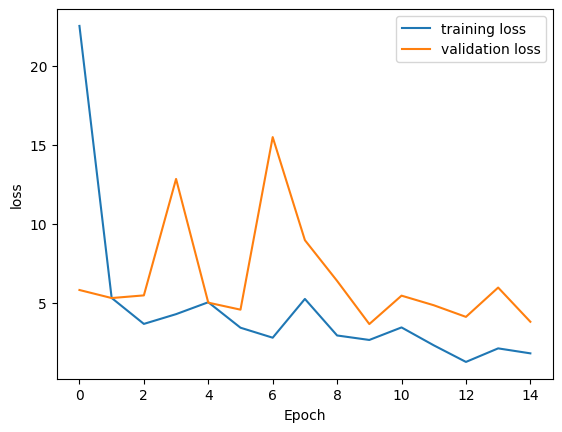

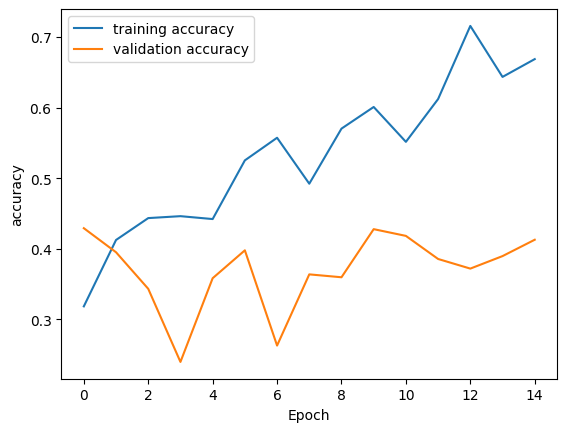

In [98]:
linear_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
  tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

linear_history = train(train_dataset, val_dataset, linear_model, num_epochs=NUM_EPOCHS)
print(linear_model.summary())
plot_results(linear_history)


### Training a neural network with ReLU activation

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.2387 - loss: 62.7756 - val_accuracy: 0.3134 - val_loss: 2.3553
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.3412 - loss: 1.8666 - val_accuracy: 0.3338 - val_loss: 1.6880
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.3807 - loss: 1.5163 - val_accuracy: 0.4087 - val_loss: 1.4656
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.4673 - loss: 1.3285 - val_accuracy: 0.3951 - val_loss: 1.5023
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.4843 - loss: 1.3609 - val_accuracy: 0.3992 - val_loss: 1.5281
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.5157 - loss: 1.1904 - val_accuracy: 0.4046 - val_loss: 1.4719
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.5466 - loss: 1.1477 - val_accuracy: 0.4373 - val_loss: 1.4034
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.5518 - loss: 1.1729 - val_accuracy: 

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,805,073 (220.51 MB)

 Trainable params: 19,268,357 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,536,716 (147.01 MB)

None


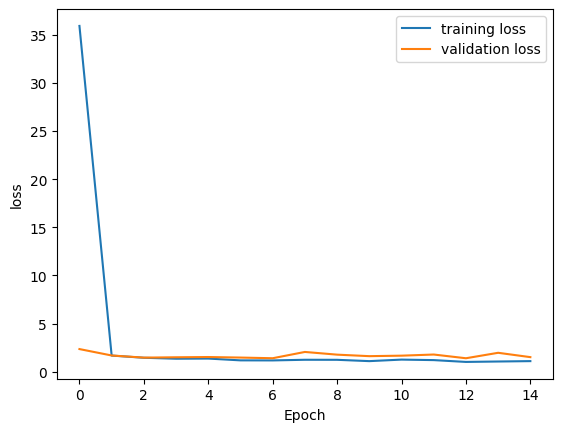

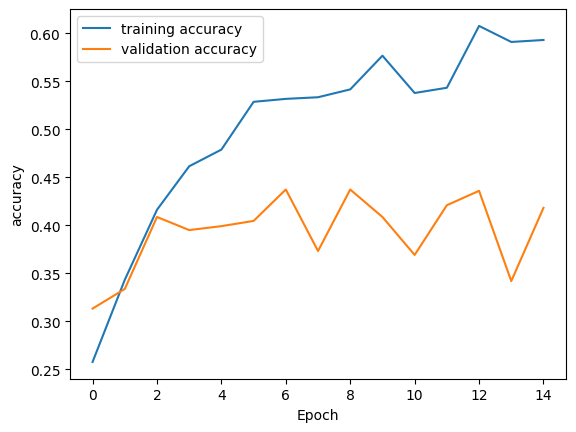

In [99]:
nn_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

nn_history = train(train_dataset, val_dataset, nn_model, num_epochs=NUM_EPOCHS)
print(nn_model.summary())
plot_results(nn_history)


## OVERFITTING PREVENTION

### 1. Regularization

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.2446 - loss: 49.8358 - val_accuracy: 0.3651 - val_loss: 2.6524
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.3810 - loss: 2.7389 - val_accuracy: 0.3338 - val_loss: 3.1458
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.4510 - loss: 2.1334 - val_accuracy: 0.3188 - val_loss: 2.3851
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.4778 - loss: 1.9154 - val_accuracy: 0.4087 - val_loss: 2.0029
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.5175 - loss: 1.8688 - val_accuracy: 0.4169 - val_loss: 2.3203
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.4869 - loss: 2.0242 - val_accuracy: 0.3869 - val_loss: 2.0948
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.5311 - loss: 1.7279 - val_accuracy: 0.4251 - val_loss: 1.8942
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.5185 - loss: 1.8148 - val_accuracy: 

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_18 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,805,073 (220.51 MB)

 Trainable params: 19,268,357 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,536,716 (147.01 MB)

None


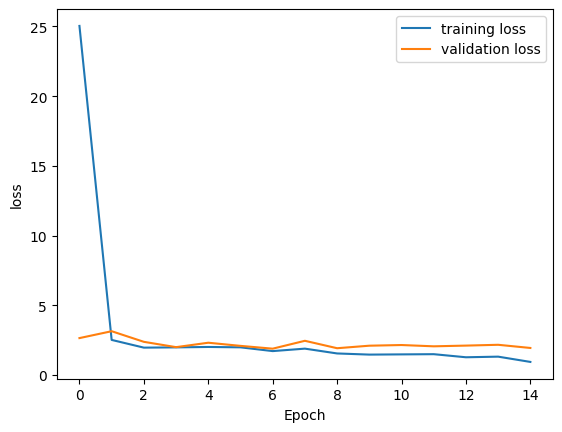

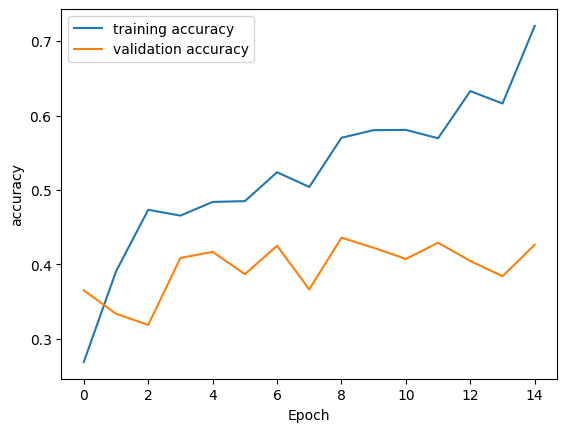

In [100]:
regularizer = tf.keras.regularizers.l2(0.001)
l2_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
  tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer, activation='softmax')
])

l2_history = train(train_dataset, val_dataset, l2_model, num_epochs=NUM_EPOCHS)
print(l2_model.summary())
plot_results(l2_history)


### 2. Dropout

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.2432 - loss: 20.3820 - val_accuracy: 0.2738 - val_loss: 1.5775
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.2935 - loss: 1.5694 - val_accuracy: 0.3433 - val_loss: 1.4953
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.2664 - loss: 1.5688 - val_accuracy: 0.2534 - val_loss: 1.5920
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.2653 - loss: 1.5921 - val_accuracy: 0.3120 - val_loss: 1.5387
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.2917 - loss: 1.5612 - val_accuracy: 0.3052 - val_loss: 1.5376
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.2758 - loss: 1.5733 - val_accuracy: 0.2425 - val_loss: 1.5991
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.2603 - loss: 1.5950 - val_accuracy: 0.2480 - val_loss: 1.5941
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.2666 - loss: 1.5781 - val_accuracy: 

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_19 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,805,073 (220.51 MB)

 Trainable params: 19,268,357 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,536,716 (147.01 MB)

None


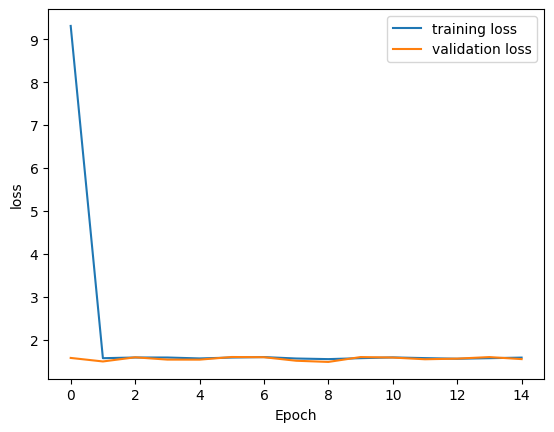

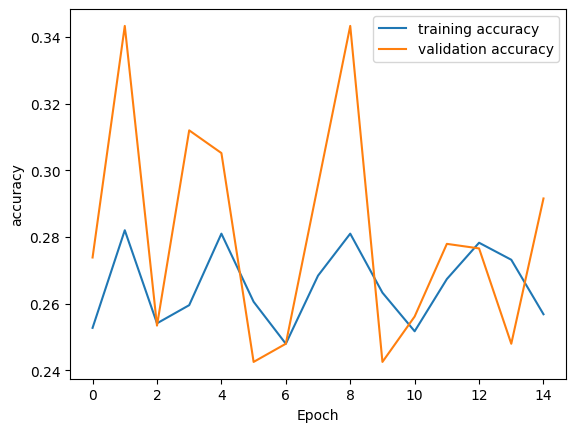

In [101]:
dropout_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

dropout_history = train(train_dataset, val_dataset, dropout_model, num_epochs=NUM_EPOCHS)
print(dropout_model.summary())
plot_results(dropout_history)


### 3. Early Stopping

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.3092 - loss: 2.4688 - val_accuracy: 0.2153 - val_loss: 1.6087
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.2315 - loss: 1.6002 - val_accuracy: 0.2302 - val_loss: 1.6258
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.2472 - loss: 1.5881 - val_accuracy: 0.2153 - val_loss: 1.6046
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.2248 - loss: 1.6011 - val_accuracy: 0.2275 - val_loss: 1.5910
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.2532 - loss: 1.5566 - val_accuracy: 0.2398 - val_loss: 1.6030
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.2533 - loss: 1.5985 - val_accuracy: 0.2398 - val_loss: 1.6025


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,805,073 (220.51 MB)

 Trainable params: 19,268,357 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,536,716 (147.01 MB)

None


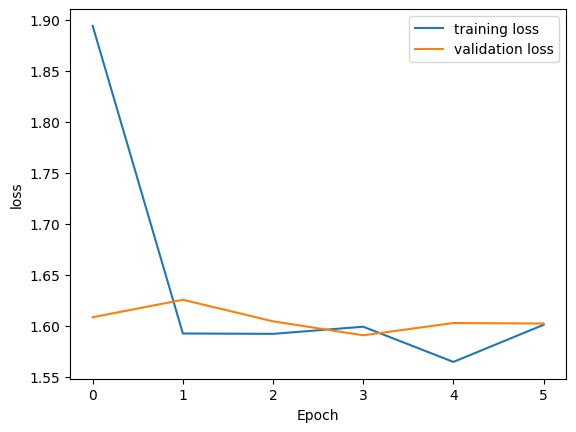

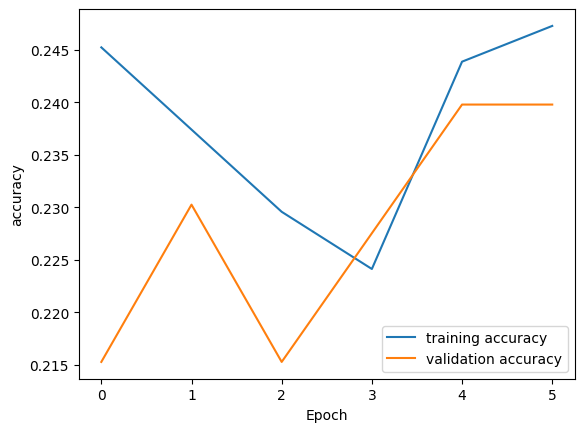

In [102]:
earlystopping_history = train(train_dataset, val_dataset, nn_model, early_stopping=True, num_epochs=NUM_EPOCHS)
print(nn_model.summary())
plot_results(earlystopping_history)


### 4. Batch Normalization

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.3842 - loss: 1.4747 - val_accuracy: 0.3610 - val_loss: 2.0355
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.4843 - loss: 1.2465 - val_accuracy: 0.4251 - val_loss: 1.3864
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.5178 - loss: 1.1846 - val_accuracy: 0.4591 - val_loss: 1.2674
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.6015 - loss: 1.0854 - val_accuracy: 0.4605 - val_loss: 1.3138
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.6423 - loss: 0.9957 - val_accuracy: 0.4591 - val_loss: 1.3087
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.7186 - loss: 0.8602 - val_accuracy: 0.3965 - val_loss: 1.3722
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7976 - loss: 0.7234 - val_accuracy: 0.3243 - val_loss: 1.5354
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.8565 - loss: 0.6182 - val_accuracy:

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_20 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,806,137 (220.51 MB)

 Trainable params: 19,268,623 (73.50 MB)

 Non-trainable params: 266 (1.04 KB)

 Optimizer params: 38,537,248 (147.01 MB)

None


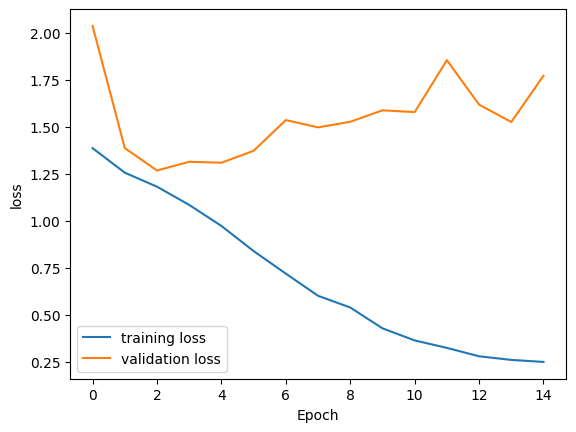

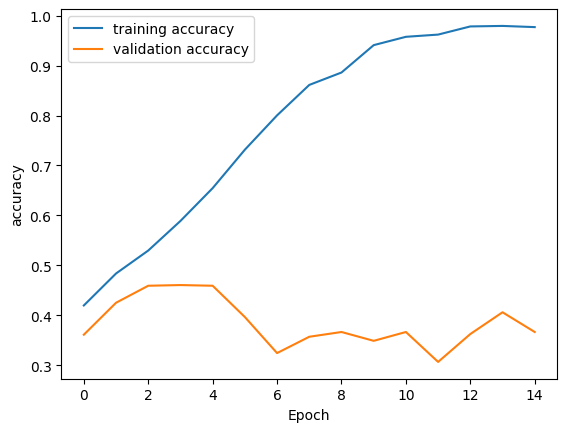

In [103]:
batchnorm_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),

  tf.keras.layers.Dense(128),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),

  tf.keras.layers.Dense(len(CLASS_NAMES)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('softmax')
])

batchnorm_history = train(train_dataset, val_dataset, batchnorm_model, num_epochs=NUM_EPOCHS)
print(batchnorm_model.summary())
plot_results(batchnorm_history)


### 5. Regularization + Batch Normalization

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.3720 - loss: 2.1003 - val_accuracy: 0.3747 - val_loss: 3.1136
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.4828 - loss: 1.9799 - val_accuracy: 0.4114 - val_loss: 1.9938
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.5354 - loss: 1.7068 - val_accuracy: 0.3801 - val_loss: 1.8227
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.5777 - loss: 1.5208 - val_accuracy: 0.4278 - val_loss: 1.7756
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.6030 - loss: 1.4038 - val_accuracy: 0.3706 - val_loss: 1.7354
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.6574 - loss: 1.2958 - val_accuracy: 0.2916 - val_loss: 2.2226
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6722 - loss: 1.2360 - val_accuracy: 0.2834 - val_loss: 1.9278
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.7075 - loss: 1.2023 - val_accuracy: 

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_21 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,806,137 (220.51 MB)

 Trainable params: 19,268,623 (73.50 MB)

 Non-trainable params: 266 (1.04 KB)

 Optimizer params: 38,537,248 (147.01 MB)

None


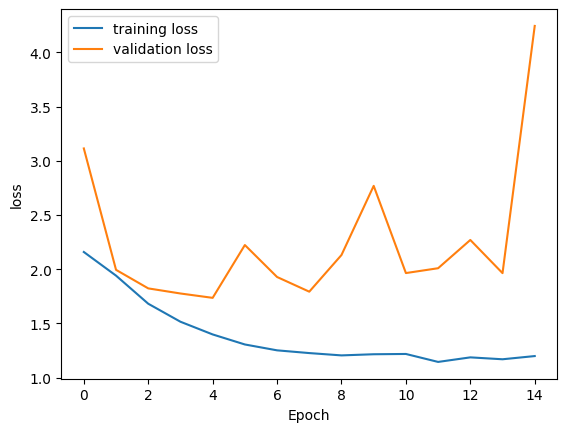

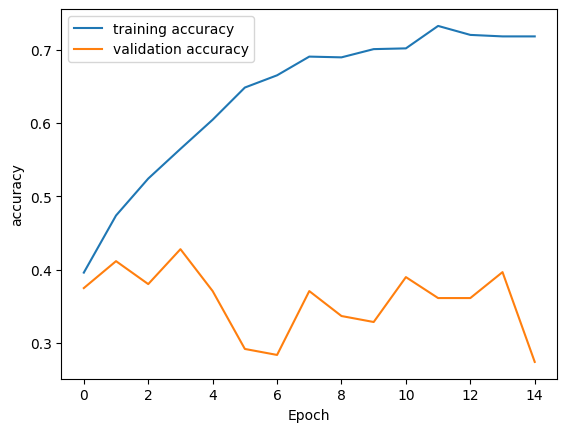

In [104]:
regularizer = tf.keras.regularizers.l2(0.001)
reg_norm_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),

  tf.keras.layers.Dense(128, kernel_regularizer=regularizer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),

  tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('softmax')
])

reg_norm_history = train(train_dataset, val_dataset, reg_norm_model, num_epochs=NUM_EPOCHS)
print(reg_norm_model.summary())
plot_results(reg_norm_history)


### 6. Regularization + Dropout + Batch Normalization

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.3697 - loss: 2.0646 - val_accuracy: 0.3569 - val_loss: 2.9961
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.4401 - loss: 2.0284 - val_accuracy: 0.4060 - val_loss: 2.0837
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.4544 - loss: 1.7961 - val_accuracy: 0.4087 - val_loss: 1.8333
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.4780 - loss: 1.6146 - val_accuracy: 0.4305 - val_loss: 1.6657
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.4976 - loss: 1.5324 - val_accuracy: 0.4033 - val_loss: 1.6501
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.5114 - loss: 1.4473 - val_accuracy: 0.3420 - val_loss: 1.7286
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.5120 - loss: 1.4257 - val_accuracy: 0.3883 - val_loss: 1.5992
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.5393 - loss: 1.3964 - val_accuracy: 0

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_22 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,806,137 (220.51 MB)

 Trainable params: 19,268,623 (73.50 MB)

 Non-trainable params: 266 (1.04 KB)

 Optimizer params: 38,537,248 (147.01 MB)

None


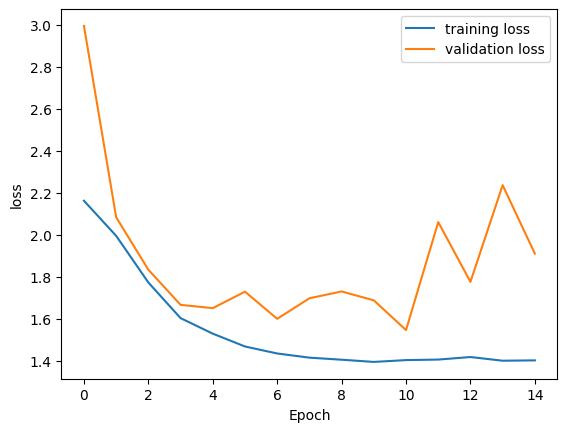

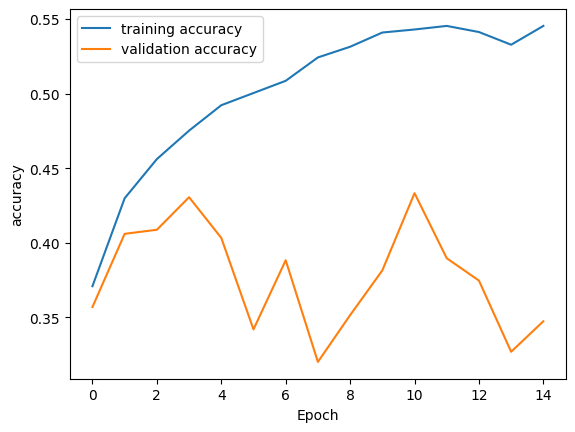

In [105]:
regularizer = tf.keras.regularizers.l2(0.001)
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),

  tf.keras.layers.Dense(128, kernel_regularizer=regularizer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('softmax')
])

history = train(train_dataset, val_dataset, model, num_epochs=NUM_EPOCHS)
print(model.summary())
plot_results(history)
